# Лабораторная работа 2. Машинное обучение.

- Ткачев Алексей Игоревич
- Группа 381806-2
- ФИИТ
- 4 курс

# Название датасета

Wine Quality Dataset.

# Описание задачи
- Обучить полносвязную неглубокую нейронную сеть распознавать качество вина.
- Постоить графики зависимости ошибки на обучеющей выборке и на тестовой от параметра альфа и количества нейронов.
- Сделать выводы.

# Все выводы (переобучение, недообучение, итоги) в конце данной работы

# Загрузка нужных библиотек

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from time import time
%matplotlib inline

# Загрузка датасета
`given_data` - весь "сырой" датасет.

In [71]:
given_data = pd.read_csv('dataset.csv', sep=',', header=0,  engine='python')

Так как `given_data` первой строкой представлял имена столбцов, то аргумент `header=0`.

In [72]:
given_data

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


## Балансировка датасета

Так как датасет имеет несбалансированные по количеству признаков относительно класса `quality`, сбалансируем его удалением слишком малых классов.

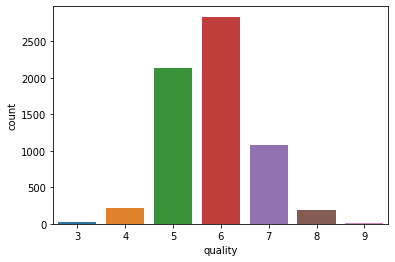

In [73]:
import seaborn as sns
sns.countplot(x='quality', data=given_data)

In [74]:
given_data.columns

Index(['type', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')

In [75]:
quality = given_data.columns[len(given_data.columns)-1]
quality

'quality'

In [76]:
given_data = given_data.drop(given_data[given_data[quality] == 3].index)
given_data = given_data.drop(given_data[given_data[quality] == 4].index)
given_data = given_data.drop(given_data[given_data[quality] == 7].index)
given_data = given_data.drop(given_data[given_data[quality] == 8].index)
given_data = given_data.drop(given_data[given_data[quality] == 9].index)

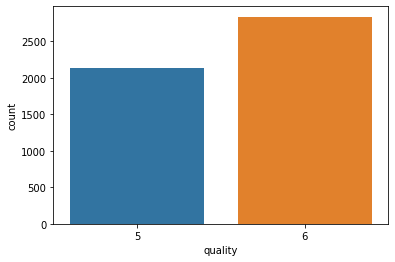

In [77]:
sns.countplot(x='quality', data=given_data)

Видим, что теперь классов `quality` всего два, но обучение будет намного точнее.

In [78]:
given_data

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


# Основные характеристики данных

Основные числое характеристики:

In [79]:
given_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4965.000000,4968.000000,4971.000000,4973.000000,4973.000000,4974.000000,4974.000000,4974.000000,4967.000000,4971.000000,4974.000000,4974.000000
mean,7.243041,0.346423,0.316880,5.659924,0.058681,30.766285,117.744069,0.995113,3.215269,0.529865,10.265275,5.570165
std,1.280200,0.165673,0.150596,4.935363,0.036438,17.604133,57.861460,0.002867,0.159417,0.144597,1.070626,0.495102
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987220,2.720000,0.230000,8.000000,5.000000
25%,6.400000,0.230000,0.240000,1.800000,0.040000,17.000000,76.000000,0.992992,3.110000,0.440000,9.400000,5.000000
50%,7.000000,0.300000,0.310000,3.100000,0.049000,29.000000,121.000000,0.995400,3.200000,0.510000,10.000000,6.000000
75%,7.700000,0.420000,0.400000,8.500000,0.070000,42.000000,160.000000,0.997200,3.320000,0.600000,11.000000,6.000000
max,15.900000,1.330000,1.660000,65.800000,0.611000,131.000000,344.000000,1.038980,4.010000,1.980000,14.900000,6.000000


Таблица корреляции:

In [80]:
given_data.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,0.245779,0.288985,-0.147009,0.277968,-0.292979,-0.335543,0.425819,-0.227387,0.303852,-0.040127,-0.058514
volatile acidity,0.245779,1.000000,-0.382587,-0.218822,0.385146,-0.368782,-0.439717,0.293125,0.274866,0.266959,-0.049147,-0.227241
citric acid,0.288985,-0.382587,1.000000,0.159680,0.026121,0.154748,0.229476,0.087842,-0.339325,0.029711,-0.020798,0.052817
residual sugar,-0.147009,-0.218822,0.159680,1.000000,-0.165767,0.453919,0.504631,0.559895,-0.248945,-0.184880,-0.356440,-0.025374
chlorides,0.277968,0.385146,0.026121,-0.165767,1.000000,-0.198275,-0.293608,0.308413,0.056817,0.405628,-0.211621,-0.142649
free sulfur dioxide,-0.292979,-0.368782,0.154748,0.453919,-0.198275,1.000000,0.733103,0.060922,-0.174936,-0.220145,-0.219735,0.026089
total sulfur dioxide,-0.335543,-0.439717,0.229476,0.504631,-0.293608,0.733103,1.000000,0.026404,-0.259041,-0.268465,-0.267935,-0.046448
density,0.425819,0.293125,0.087842,0.559895,0.308413,0.060922,0.026404,1.000000,0.052646,0.273445,-0.641054,-0.222920
pH,-0.227387,0.274866,-0.339325,-0.248945,0.056817,-0.174936,-0.259041,0.052646,1.000000,0.188407,0.109301,0.017576
sulphates,0.303852,0.266959,0.029711,-0.184880,0.405628,-0.220145,-0.268465,0.273445,0.188407,1.000000,-0.015696,0.020719


с помощью `seaborn` библиотеки отобразим нагляднее корреляцию данных.

воспользуемся маской `np_triu()`, чтобы исключить повторяющиеся ячейки.

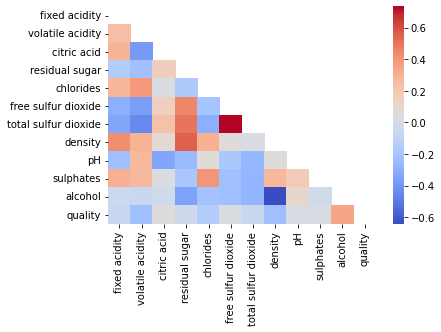

In [81]:
import seaborn as sb
mask = np.triu(given_data.corr())
sb.heatmap(given_data.corr(), mask=mask, cmap='coolwarm')
pass

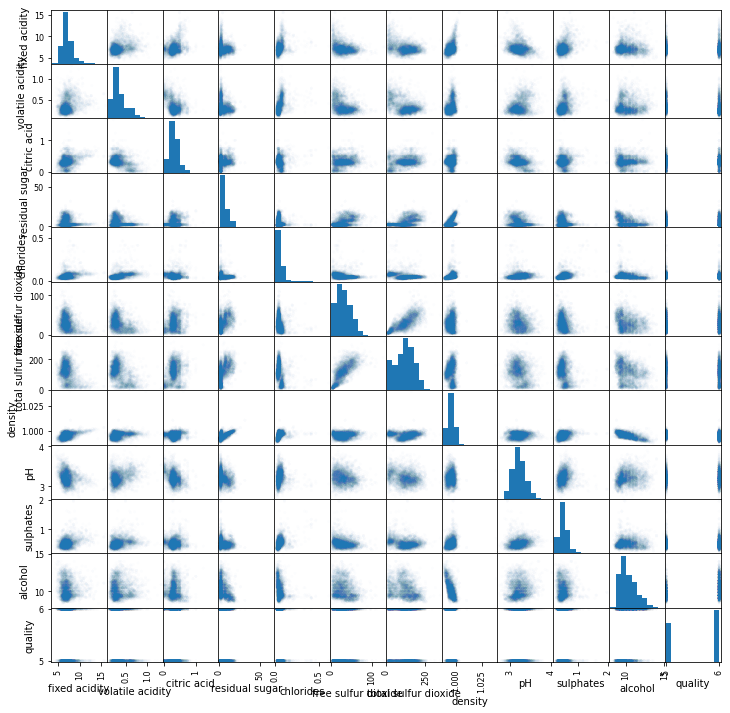

In [82]:
from pandas.plotting import scatter_matrix
scatter_matrix(given_data, alpha = .01, figsize = (12, 12))
pass

# Есть пустые значения?

Вопрос: есть ли пустые значения?

In [83]:
given_data.dropna()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6491,red,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [84]:
print(given_data.shape)
print(given_data.dropna(axis = 0).shape)

(4974, 13)
(4948, 13)


Видим, что ~30 строк было выкинуто. Значит, пустые значения есть. Обработаем пустые значения.

# Обработка пустых значений

Найдем столбы для строковых данных `categorical_columns`, и численных `num_columns`

In [85]:
categorical_columns = [column for column in given_data.columns if given_data[column].dtype.name == 'object']
num_columns = [column for column in given_data.columns if given_data[column].dtype.name != 'object' and column != 'quality']

Теперь заполним пустые значения медианными (средними) значениями по каждому столбцу

In [86]:
median = given_data.median(axis = 0, numeric_only=True)

In [87]:
given_data = given_data.fillna(median, axis=0)

In [88]:
given_data[num_columns].count(axis = 0)

fixed acidity           4974
volatile acidity        4974
citric acid             4974
residual sugar          4974
chlorides               4974
free sulfur dioxide     4974
total sulfur dioxide    4974
density                 4974
pH                      4974
sulphates               4974
alcohol                 4974
dtype: int64

In [89]:
given_data[categorical_columns].count(axis = 0)

type    4974
dtype: int64

Теперь можно выделить выборки `X` - все данные кроме ключевого столбца, и `Y` - один ключевой столбец

In [90]:
given_data.dropna(axis=0)
Y = given_data['quality']
X = given_data.drop('quality', axis=1)

In [91]:
X

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.51,11.2
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2


In [92]:
Y

0       6
1       6
2       6
3       6
4       6
       ..
6492    5
6493    6
6494    6
6495    5
6496    6
Name: quality, Length: 4974, dtype: int64

## Количество классов:

In [93]:
print(np.unique(Y))
print(len(np.unique(Y)))

[5 6]
2


# Векторизация

In [94]:
data_describe = X.describe(include = [object])
for column in categorical_columns:
    X[column] = X[column].fillna(data_describe[column]['top'])
data_describe

,type
count,4974
unique,2
top,white
freq,3655


In [95]:
binary_columns  = [column for column in categorical_columns if data_describe[column]['unique'] == 2]
non_binary_columns = [column for column in categorical_columns if data_describe[column]['unique'] > 2]
print(binary_columns, non_binary_columns)

['type'] []


In [96]:
X['type'].unique()

array(['white', 'red'], dtype=object)

In [97]:
X.at[X['type'] == 'white', 'type'] = 0
X.at[X['type'] == 'red', 'type'] = 1
X['type'].astype('float64').describe()

count    4974.000000
mean        0.265179
std         0.441473
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: type, dtype: float64

In [98]:
X['type']

0       0
1       0
2       0
3       0
4       0
       ..
6492    1
6493    1
6494    1
6495    1
6496    1
Name: type, Length: 4974, dtype: object

# Нормализация

В целом, если смотреть, данные весьма разнородные, если достаточно низние значения, есть высокие, а больше всего и вовсе средних. В целях увеличиния точности, проведем нормализацию всех числовых ячеек.

In [99]:
num_data = X[num_columns].astype('float64')
num_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,4974.000000,4974.000000,4974.000000,4974.000000,4974.000000,4974.000000,4974.000000,4974.000000,4974.000000,4974.000000,4974.000000
mean,7.242602,0.346367,0.316876,5.659409,0.058679,30.766285,117.744069,0.995113,3.215247,0.529853,10.265275
std,1.279083,0.165580,0.150550,4.935000,0.036434,17.604133,57.861460,0.002867,0.159306,0.144554,1.070626
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987220,2.720000,0.230000,8.000000
25%,6.400000,0.230000,0.240000,1.800000,0.040000,17.000000,76.000000,0.992992,3.110000,0.440000,9.400000
50%,7.000000,0.300000,0.310000,3.100000,0.049000,29.000000,121.000000,0.995400,3.200000,0.510000,10.000000
75%,7.700000,0.420000,0.400000,8.500000,0.070000,42.000000,160.000000,0.997200,3.310000,0.600000,11.000000
max,15.900000,1.330000,1.660000,65.800000,0.611000,131.000000,344.000000,1.038980,4.010000,1.980000,14.900000


In [100]:
num_data = (num_data - num_data.mean(axis = 0)) / num_data.std(axis = 0)

In [101]:
num_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,4.974000e+03,4.974000e+03,4.974000e+03,4.974000e+03,4.974000e+03,4.974000e+03,4.974000e+03,4.974000e+03,4.974000e+03,4.974000e+03,4.974000e+03
mean,1.644746e-14,-2.219743e-15,1.349664e-14,-1.648382e-15,-1.038304e-14,-6.247516e-17,-1.041610e-15,2.019527e-12,-7.573444e-15,8.152573e-16,-7.321356e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.691461e+00,-1.608687e+00,-2.104785e+00,-1.025210e+00,-1.363535e+00,-1.690869e+00,-1.931235e+00,-2.753565e+00,-3.108787e+00,-2.074327e+00,-2.115841e+00
25%,-6.587544e-01,-7.027829e-01,-5.106320e-01,-7.820485e-01,-5.126865e-01,-7.819916e-01,-7.214486e-01,-7.397883e-01,-6.606626e-01,-6.215874e-01,-8.081956e-01
50%,-1.896683e-01,-2.800277e-01,-4.567084e-02,-5.186239e-01,-2.656660e-01,-1.003335e-01,5.627115e-02,1.000849e-01,-9.571089e-02,-1.373409e-01,-2.477759e-01
75%,3.575988e-01,4.446956e-01,5.521364e-01,5.756011e-01,3.107153e-01,6.381294e-01,7.302949e-01,7.280275e-01,5.947856e-01,4.852618e-01,6.862568e-01
max,6.768442e+00,5.940514e+00,8.921438e+00,1.218654e+01,1.515939e+01,5.693760e+00,3.910305e+00,1.530327e+01,4.988854e+00,1.003184e+01,4.328984e+00


# Соединние `num_data` и `X[binary_columns]`

In [102]:
X = pd.concat((num_data, X[binary_columns]), axis = 1)
X.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,4.974000e+03,4.974000e+03,4.974000e+03,4.974000e+03,4.974000e+03,4.974000e+03,4.974000e+03,4.974000e+03,4.974000e+03,4.974000e+03,4.974000e+03
mean,1.644746e-14,-2.219743e-15,1.349664e-14,-1.648382e-15,-1.038304e-14,-6.247516e-17,-1.041610e-15,2.019527e-12,-7.573444e-15,8.152573e-16,-7.321356e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.691461e+00,-1.608687e+00,-2.104785e+00,-1.025210e+00,-1.363535e+00,-1.690869e+00,-1.931235e+00,-2.753565e+00,-3.108787e+00,-2.074327e+00,-2.115841e+00
25%,-6.587544e-01,-7.027829e-01,-5.106320e-01,-7.820485e-01,-5.126865e-01,-7.819916e-01,-7.214486e-01,-7.397883e-01,-6.606626e-01,-6.215874e-01,-8.081956e-01
50%,-1.896683e-01,-2.800277e-01,-4.567084e-02,-5.186239e-01,-2.656660e-01,-1.003335e-01,5.627115e-02,1.000849e-01,-9.571089e-02,-1.373409e-01,-2.477759e-01
75%,3.575988e-01,4.446956e-01,5.521364e-01,5.756011e-01,3.107153e-01,6.381294e-01,7.302949e-01,7.280275e-01,5.947856e-01,4.852618e-01,6.862568e-01
max,6.768442e+00,5.940514e+00,8.921438e+00,1.218654e+01,1.515939e+01,5.693760e+00,3.910305e+00,1.530327e+01,4.988854e+00,1.003184e+01,4.328984e+00


In [103]:
X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,-0.189668,-0.461209,0.286444,3.047739,-0.375453,0.808544,0.903122,2.053684,-1.351159,-0.552409,-1.368615,0
1,-0.736935,-0.280028,0.153598,-0.822575,-0.265666,-0.952406,0.246380,-0.388315,0.532013,-0.275697,-0.714792,0
2,0.670323,-0.400815,0.552136,0.251386,-0.238219,-0.043529,-0.358513,-0.004572,0.280924,-0.621587,-0.154373,0
3,-0.033306,-0.702783,0.020752,0.575601,-0.018645,0.922154,1.179644,0.169856,-0.158483,-0.898300,-0.341179,0
4,-0.033306,-0.702783,0.020752,0.575601,-0.018645,0.922154,1.179644,0.169856,-0.158483,-0.898300,-0.341179,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,-0.815116,1.531781,-1.573400,-0.741522,0.859650,0.070081,-1.274494,-0.074344,1.473599,0.346906,0.219240,1
6493,-1.049659,1.229812,-1.440554,-0.700995,0.091141,0.467715,-1.153515,0.002405,1.913006,-0.137341,0.873063,1
6494,-0.736935,0.988238,-1.241285,-0.680731,0.475396,-0.100334,-1.343624,0.218696,1.285282,1.522933,0.686257,1
6495,-1.049659,1.803552,-1.307708,-0.741522,0.447949,0.070081,-1.274494,0.124505,2.226868,1.246221,-0.060969,1


In [104]:
print(X.shape)

(4974, 12)


In [105]:
features = X.columns
features

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'type'],
      dtype='object')

In [106]:
type(features)

pandas.core.indexes.base.Index

In [107]:
X = X.to_numpy()

In [108]:
Y = Y.to_numpy(dtype='int32')

In [109]:
print(X.shape)
print(Y.shape)
N, d = X.shape

(4974, 12)
(4974,)


In [110]:
type(X)

numpy.ndarray

In [111]:
type(Y)

numpy.ndarray

In [112]:
np.unique(Y)

array([5, 6], dtype=int32)

# Обучение полносвязаной неглубокой нейронной сети без подбора параметров

In [113]:
hidden_layers_1 = (70,)
hidden_layers_2 = (45, 25)
test_part = 0.15

## Функция обучения

In [114]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

def learn_neural(hidden_layers):
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = test_part, random_state = 42)
  N_train, _ = X_train.shape 
  N_test,  _ = X_test.shape 
  model = MLPClassifier(hidden_layer_sizes = hidden_layers, solver = 'adam', 
                          activation = 'logistic', max_iter=2000,
                          random_state = 42, verbose=1, tol=1e-3)
  model.fit(X_train, y_train)
  return X_train, X_test, y_train, y_test, model

## 1 слой

In [115]:
X_train, X_test, y_train, y_test, model = learn_neural(hidden_layers_1)
y_test_predict = model.predict(X_test)
y_train_predict = model.predict(X_train)
err_test  = np.mean(y_test != y_test_predict)
err_train  = np.mean(y_train != y_train_predict)

Iteration 1, loss = 0.69775664
Iteration 2, loss = 0.66353331
Iteration 3, loss = 0.65145856
Iteration 4, loss = 0.64052413
Iteration 5, loss = 0.63126042
Iteration 6, loss = 0.62360372
Iteration 7, loss = 0.61640969
Iteration 8, loss = 0.61029940
Iteration 9, loss = 0.60506851
Iteration 10, loss = 0.60074074
Iteration 11, loss = 0.59728120
Iteration 12, loss = 0.59295792
Iteration 13, loss = 0.59043685
Iteration 14, loss = 0.58867408
Iteration 15, loss = 0.58628860
Iteration 16, loss = 0.58460380
Iteration 17, loss = 0.58332743
Iteration 18, loss = 0.58255109
Iteration 19, loss = 0.58185527
Iteration 20, loss = 0.58106550
Iteration 21, loss = 0.58124891
Iteration 22, loss = 0.58127939
Iteration 23, loss = 0.58044322
Iteration 24, loss = 0.57975047
Iteration 25, loss = 0.57940008
Iteration 26, loss = 0.57925147
Iteration 27, loss = 0.57910227
Iteration 28, loss = 0.57939072
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.


In [116]:
err_test, err_train

(0.29451137884872824, 0.30021291696238467)

## 2 слоя

In [117]:
X_train, X_test, y_train, y_test, model = learn_neural(hidden_layers_2)
y_test_predict = model.predict(X_test)
y_train_predict = model.predict(X_train)
err_test = np.mean(y_test != y_test_predict)
err_train = np.mean(y_train != y_train_predict)

Iteration 1, loss = 0.68762021
Iteration 2, loss = 0.67812434
Iteration 3, loss = 0.67275734
Iteration 4, loss = 0.66772276
Iteration 5, loss = 0.66111414
Iteration 6, loss = 0.65356056
Iteration 7, loss = 0.64441764
Iteration 8, loss = 0.63474492
Iteration 9, loss = 0.62483688
Iteration 10, loss = 0.61582906
Iteration 11, loss = 0.60904119
Iteration 12, loss = 0.60222007
Iteration 13, loss = 0.59729191
Iteration 14, loss = 0.59349137
Iteration 15, loss = 0.59026135
Iteration 16, loss = 0.58826656
Iteration 17, loss = 0.58658707
Iteration 18, loss = 0.58508683
Iteration 19, loss = 0.58348457
Iteration 20, loss = 0.58263518
Iteration 21, loss = 0.58206244
Iteration 22, loss = 0.58134956
Iteration 23, loss = 0.58169318
Iteration 24, loss = 0.58100234
Iteration 25, loss = 0.58035579
Iteration 26, loss = 0.58002156
Iteration 27, loss = 0.58032438
Iteration 28, loss = 0.58070164
Iteration 29, loss = 0.58047902
Iteration 30, loss = 0.58053000
Training loss did not improve more than tol=0.001

In [118]:
err_test, err_train

(0.2958500669344043, 0.3030518097941803)

## Выводы

Два слоя оказались более ошибочными нежели один, или практически такими же. Поэтому в дальнейшем будем работать и подбирать параметры только в рамках одного слоя, так как это проще и точнее.

# Подбор `alpha`

## Функция обучения

In [119]:
alpha = np.logspace(-7, 3, 21)

In [120]:
from sklearn.metrics import accuracy_score
import tqdm
def learn_neural_alpha(alpha, hidden_layer):
  test_error_list = []
  train_error_list = []
  train_accuracy = []
  test_accuracy = []
  model = MLPClassifier(alpha=alpha[0], hidden_layer_sizes= hidden_layer, solver = 'adam', activation = 'logistic', max_iter=2000, random_state = 42, tol=1e-3)
  for a in tqdm.tqdm_notebook(alpha):
    model = MLPClassifier(alpha=a, hidden_layer_sizes = hidden_layer, solver = 'adam', activation = 'logistic', max_iter=2000, random_state = 42, tol=1e-3)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_error_list.append(np.mean(y_train != y_train_pred))
    test_error_list.append(np.mean(y_test != y_test_pred))
    train_accuracy.append(accuracy_score(y_train, y_train_pred))
    test_accuracy.append(accuracy_score(y_test, y_test_pred))
  return train_error_list, test_error_list, train_accuracy, test_accuracy, model

## 1 слой

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/21 [00:00<?, ?it/s]

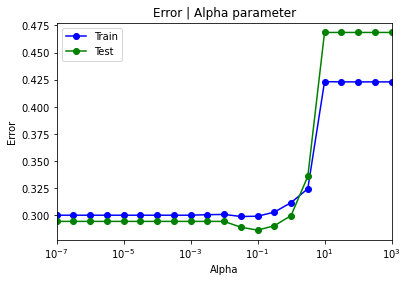

In [121]:
train_error_list, test_error_list, train_accuracy_list, test_accuracy_list, model = learn_neural_alpha(alpha, hidden_layers_1)
plt.semilogx(alpha, train_error_list, 'b-o', label = 'Train')
plt.semilogx(alpha, test_error_list, 'g-o', label = 'Test')
plt.xlim([np.min(alpha), np.max(alpha)])
plt.title('Error | Alpha parameter')
plt.xlabel('Alpha')
plt.ylabel('Error')
plt.legend()

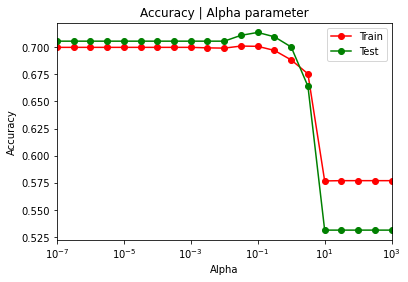

In [122]:
plt.semilogx(alpha, train_accuracy_list, 'r-o', label = 'Train')
plt.semilogx(alpha, test_accuracy_list, 'g-o', label = 'Test')
plt.xlim([np.min(alpha), np.max(alpha)])
plt.title('Accuracy | Alpha parameter')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.legend()

In [123]:
np.min(train_error_list), np.min(train_error_list)

(0.2990300449491365, 0.2990300449491365)

In [124]:
alpha_optimal = alpha[np.min(train_error_list) == np.min(train_error_list)][0][0]

# Подбор количества нейронов

In [125]:
neurons_count_list = np.array([i for i in range(2, 100+1)])

In [126]:
def learn_neural_neurons(neurons_count_list, alpha):
  train_accuracy_list = []
  test_accuracy_list = []
  test_error_list = []
  train_error_list = []
  model = MLPClassifier(alpha=alpha, hidden_layer_sizes = (neurons_count_list[0],),
                              solver = 'adam',  activation = 'logistic',
                              max_iter=2000, random_state = 42,
                              tol=1e-3)
  for n in tqdm.tqdm_notebook(neurons_count_list):
    model = MLPClassifier(alpha=alpha, hidden_layer_sizes = (n,),
                              solver = 'adam',  activation = 'logistic',
                              max_iter=2000, random_state = 42,
                              tol=1e-3)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_error_list.append(np.mean(y_train != y_train_pred))
    test_error_list.append(np.mean(y_test != y_test_pred))
    train_accuracy_list.append(accuracy_score(y_train, y_train_pred))
    test_accuracy_list.append(accuracy_score(y_test, y_test_pred))
  return train_error_list, test_error_list, train_accuracy_list, test_accuracy_list , model

## 1 слой

In [127]:
train_error_list, test_error_list, train_accuracy_list, test_accuracy_list , model = learn_neural_neurons(neurons_count_list, alpha_optimal)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/99 [00:00<?, ?it/s]

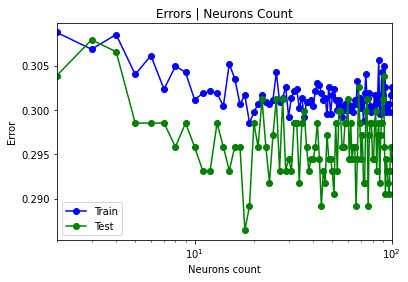

In [128]:
plt.semilogx(neurons_count_list, train_error_list, 'b-o', label = 'Train')
plt.semilogx(neurons_count_list, test_error_list, 'g-o', label = 'Test')
plt.xlim([np.min(neurons_count_list), np.max(neurons_count_list)])
plt.title('Errors | Neurons Count')
plt.xlabel('Neurons count')
plt.ylabel('Error')
plt.legend()

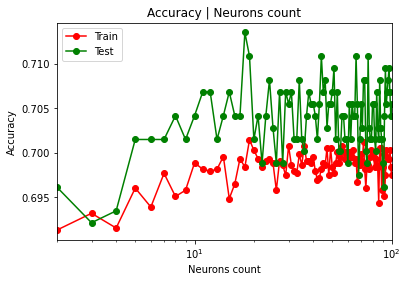

In [129]:
plt.semilogx(neurons_count_list, train_accuracy_list, 'r-o', label = 'Train')
plt.semilogx(neurons_count_list, test_accuracy_list, 'g-o', label = 'Test')
plt.xlim([np.min(neurons_count_list), np.max(neurons_count_list)])
plt.title('Accuracy | Neurons count')
plt.xlabel('Neurons count')
plt.ylabel('Accuracy')
plt.legend()

In [130]:
max_accuracy = max(test_accuracy_list)
max_id = 0
for i in range(len(test_accuracy_list)):
  if test_accuracy_list[i] == max_accuracy:
    max_id = i
optimal_count_neurons = neurons_count_list[max_id]

# Результаты и итоговое обучение на основе оптимальных параметров

In [131]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes = (optimal_count_neurons,),
                          alpha=alpha_optimal, solver = 'adam', 
                          activation = 'logistic', max_iter=2000,
                          random_state = 42, tol=1e-3)
model.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=1e-07, hidden_layer_sizes=(18,),
              max_iter=2000, random_state=42, tol=0.001)

In [132]:
y_test_predict = model.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)
err_test

0.28647925033467203

In [133]:
y_train_predict = model.predict(X_train)
err_train  = np.mean(y_train  != y_train_predict)
err_train

0.3016323633782825

# Интерпретация результатов

In [134]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_predict, y_test))

[[218  82]
 [132 315]]


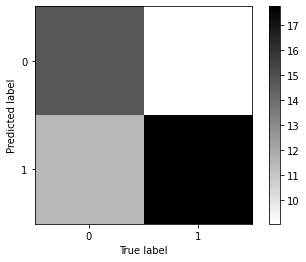

In [135]:
M = confusion_matrix(y_test_predict, y_test)
M = np.sqrt(M)
plt.imshow(M, interpolation = 'nearest')
plt.set_cmap('binary')
plt.xticks(range(2))
plt.yticks(range(2))
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.colorbar()
pass

In [136]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_predict))

              precision    recall  f1-score   support

           5       0.66      0.58      0.62      1788
           6       0.72      0.78      0.75      2439

    accuracy                           0.70      4227
   macro avg       0.69      0.68      0.69      4227
weighted avg       0.70      0.70      0.70      4227



# Общие вывод (переобучение, недобучение, итоги)

**Переобучение** не наблюдается, так как ошибка на тестовых данных не сильно отличается от тренировочных. Более того, они очень схожи, что говорит о хорошей обученности сети.

**Недообучение** есть и выражается малым количеством данных и признаков. Меняя параметр доли тестовой выборки можно достигнуть уменьшения ошибки, но для общности картины оставили ее долю равной 0.25. Это говорит о том, что при увеличении количества данных точность будет увеличиваться, что говорит о **недообученности** выборки данных в данной работе.

В ходе работы был уменьшен и сбалансирован датасет относительно класса Quality, что уменьшило ошибку с 50% до 30% (в ходе работы это не показано, но было выявленно путем тестирования). Из-за малых размеров ошибка у нейронных сетей существенна, так как нейронные сети лучше подходят для больших массивов данных. Однако в ходе работы получилось подобрать оптимальное количество слоев (1 или 2), параметр альфа и количество нейронов на слоях. 

**По итогу работы, изначальная ошибка равная примерно 30% уменьшилась до 28%.**

В ходе работы была обучена полносвязная нейронная сеть и были подобраны параметры.

# Спасибо за внимание!